In [2]:
from svb_models_asl import AslRestModel
import numpy as np 
import matplotlib.pyplot as plt 
from svb.data import VolumetricModel
import nibabel as nib 
import regtricks as rt
from scipy.ndimage import binary_dilation 

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
tau = 1.0
t = np.arange(0, 4, 0.01)
att = 1.3 
cbf = 60 
T1b = 1.6 
T1 = 1.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


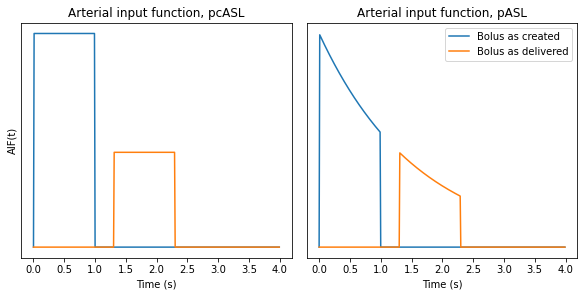

In [4]:
pcasl_bolus = np.zeros_like(t)
mask = (t < 1) & (t > 0)
pcasl_bolus[mask] = 1 
pcasl_bolus_att = np.zeros_like(t)
pcasl_bolus_att[ (t > att) & (t < (att + tau)) ] = np.exp(-att / T1b)

pasl_bolus = np.zeros_like(t)
mask = (t < 1) & (t > 0)
pasl_bolus[mask] = np.exp(-t[mask] / T1b) 
pasl_bolus_att = np.zeros_like(t)
pasl_bolus_att[ (t > att) & (t < (att + tau)) ] = np.exp(-( t[(t > att) & (t < (att + tau))] ) / T1b)

fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4), sharey=True)

axes[0].plot(t, pcasl_bolus)
axes[0].plot(t, pcasl_bolus_att)
axes[0].set_title('Arterial input function, pcASL')
axes[0].set_xlabel('Time (s)')
axes[0].set_yticks([])
axes[0].set_ylabel('AIF(t)')

axes[1].plot(t, pasl_bolus)
axes[1].plot(t, pasl_bolus_att)
# axes[1].plot(t, np.exp(-t / T1b))
axes[1].set_title('Arterial input function, pASL')
axes[1].set_xlabel('Time (s)')
axes[1].set_yticks([])

plt.legend(['Bolus as created', 'Bolus as delivered'])
plt.savefig('aif_profiles.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


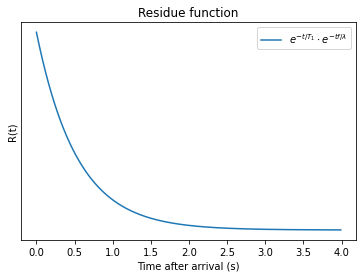

In [14]:
rd = np.exp(-t / T1) * np.exp(-t * 1 / 0.9)
fig = plt.figure(figsize=(6,4))
plt.plot(t, rd)
plt.title('Residue function')
plt.xlabel('Time after arrival (s)')
plt.legend([ r'$e^{-t / T_1} \cdot e^{-tf/\lambda}$' ])
plt.yticks([])
plt.ylabel('R(t)')
plt.savefig('residue.eps', bbox_inches='tight')
plt.show()

In [16]:
def simulate_data(cbf, att, kwargs):
    vm = VolumetricModel(np.zeros( (1,1,1,len(kwargs['plds'])) ))
    model = AslRestModel(vm, **kwargs)

    tpts = model.tpts()
    with tf.Session() as sess:
        ones = np.ones([1, 1], dtype=np.float32)
        data = sess.run(model.evaluate([
            cbf * ones, att * ones,
        ], tpts)).squeeze()
    return data 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


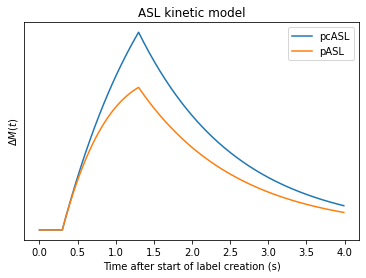

In [17]:
pcasl = simulate_data(cbf, att, {'casl': True, 'tau': 1.0, 'plds': t})
pasl = simulate_data(cbf, att, {'casl': False, 'tau': 1.0, 'plds': t})

plt.figure(figsize=(6,4))
plt.plot(t, pcasl)
plt.plot(t, pasl)
plt.xlabel('Time after start of label creation (s)')
plt.yticks([])
plt.legend(['pcASL', 'pASL'])
plt.title('ASL kinetic model')
plt.ylabel(r'$\Delta M(t)$')
plt.savefig('kinetic_curves.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


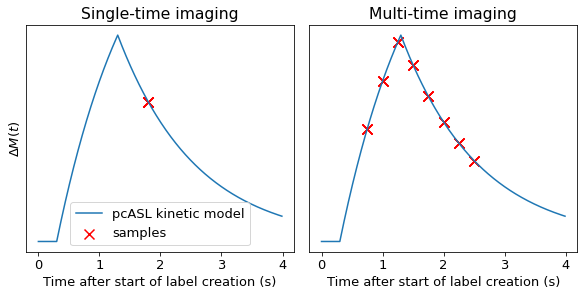

In [18]:
fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4), sharey=True)

n_samples = 10
sample_times = [1.8, 2.2]
pcasl_samples = simulate_data(cbf, att, {'casl': True, 'tau': 1.0, 'plds': sample_times})
noisy = (np.random.normal(0, 0, size=(n_samples, len(sample_times))) + pcasl_samples)[:,0]
sample_times = np.tile(sample_times, (n_samples, 1))[:,0]
axes[0].plot(t, pcasl, label="pcASL kinetic model")
axes[0].scatter(sample_times, noisy, s=100, color='r', marker='x', label='samples')
axes[0].set_title('Single-time imaging')
axes[0].legend()
axes[0].set_ylabel(r'$\Delta M(t)$')

n_samples = 4
sample_times = np.arange(0.75, 2.75, 0.25)
pcasl_samples = simulate_data(cbf, att, {'casl': True, 'tau': 1.0, 'plds': sample_times})
noisy = (np.random.normal(0, 0, size=(n_samples, len(sample_times))) + pcasl_samples)
sample_times = np.tile(sample_times, (n_samples, 1))
axes[1].plot(t, pcasl)
axes[1].scatter(sample_times, noisy, s=100, color='r', marker='x')
axes[1].set_title('Multi-time imaging')

for ax in axes: 
    ax.set_yticks([])
    ax.set_xlabel('Time after start of label creation (s)')
    
plt.savefig('single_multi.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


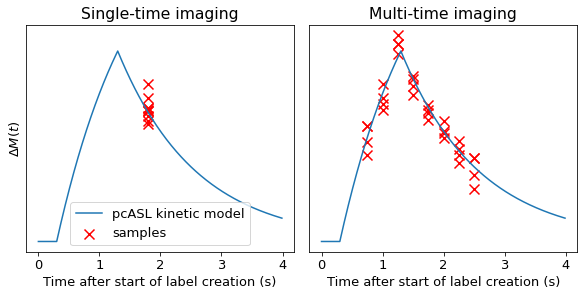

In [19]:
fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4), sharey=True)

n_samples = 10
sample_times = [1.8, 2.2]
pcasl_samples = simulate_data(cbf, att, {'casl': True, 'tau': 1.0, 'plds': sample_times})
noisy = (np.random.normal(0, 2, size=(n_samples, len(sample_times))) + pcasl_samples)[:,0]
sample_times = np.tile(sample_times, (n_samples, 1))[:,0]
axes[0].plot(t, pcasl, label="pcASL kinetic model")
axes[0].scatter(sample_times, noisy, s=100, color='r', marker='x', label='samples')
axes[0].set_title('Single-time imaging')
axes[0].legend()
axes[0].set_ylabel(r'$\Delta M(t)$')


n_samples = 4
sample_times = np.arange(0.75, 2.75, 0.25)
pcasl_samples = simulate_data(cbf, att, {'casl': True, 'tau': 1.0, 'plds': sample_times})
noisy = (np.random.normal(0, 2, size=(n_samples, len(sample_times))) + pcasl_samples)
sample_times = np.tile(sample_times, (n_samples, 1))
axes[1].plot(t, pcasl)
axes[1].scatter(sample_times, noisy, s=100, color='r', marker='x')
axes[1].set_title('Multi-time imaging')

for ax in axes: 
    ax.set_yticks([])
    ax.set_xlabel('Time after start of label creation (s)')
    
plt.savefig('single_multi_noisy.eps', bbox_inches='tight')

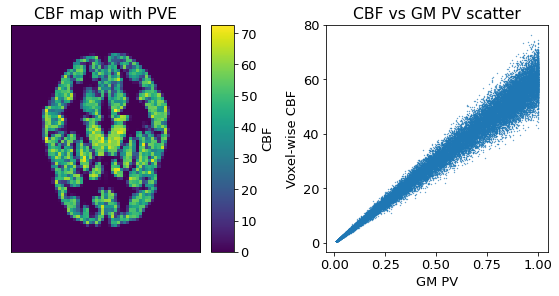

In [20]:
pvs = nib.load('tob_all_stacked_3.0.nii.gz').get_fdata()
mask = (pvs[...,0] > 0.01)
cbf = pvs[...,0] * np.random.normal(60, 5, size=mask.shape)

fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4))

im = axes[0].imshow(cbf[...,25].T)
fig.colorbar(im, ax=axes[0], label='CBF')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('CBF map with PVE')

axes[1].scatter(pvs[mask,0], cbf[mask], s=0.1)
axes[1].set_xlabel('GM PV')
axes[1].set_ylabel('Voxel-wise CBF')
axes[1].set_title('CBF vs GM PV scatter')
plt.savefig('CBF_with_PVE.eps', bbox_inches='tight')

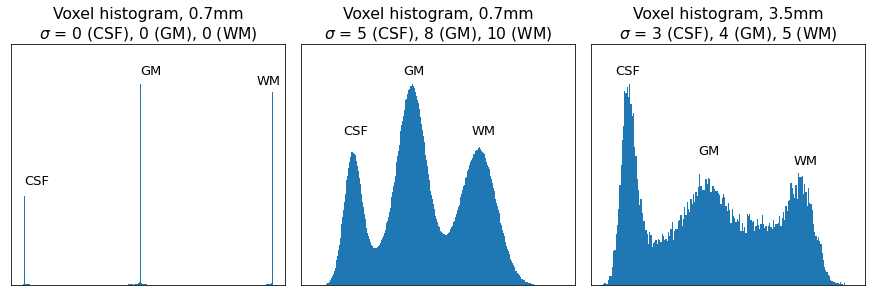

In [22]:
pvs = nib.load('tob_all_stacked_0.7.nii.gz').get_fdata()
mask = (pvs[...,:2] > 0.001).any(-1)
mask = binary_dilation(mask, iterations=3)

fig, axes = plt.subplots(1,3, constrained_layout=True, figsize=(12,4))
plt.rcParams.update({'font.size': 13})

for i in range(2): 

    t1_sim = np.zeros(mask.shape)
    t1_sim[mask] = ((pvs[mask,0] * np.random.normal(60, 8*i, size=mask.sum())) 
                    + (pvs[mask,1] * np.random.normal(100, 10*i, size=mask.sum())) 
                    + (pvs[mask,2] * np.random.normal(25, 5*i, size=mask.sum())))

    counts, bins, _ = axes[i].hist(t1_sim[mask], 300)
    axes[i].set_xticks([])
    axes[i].set_yticks([]); axes[i].set_ylim(0, 1.2 * counts.max())

    if i == 0:
        axes[0].set_title('Voxel histogram, 0.7mm\n' + r'$\sigma$ = 0 (CSF), 0 (GM), 0 (WM)')
        axes[0].text(25, 0.50 * counts.max(), 'CSF')
        axes[0].text(60, 1.05 * counts.max(), 'GM')
        axes[0].text(95, 1 * counts.max(), 'WM')

    else: 
        axes[1].set_title('Voxel histogram, 0.7mm\n' + r'$\sigma$ = 5 (CSF), 8 (GM), 10 (WM)')
        axes[1].text(20, 0.75 * counts.max(), 'CSF')
        axes[1].text(55, 1.05 * counts.max(), 'GM')
        axes[1].text(95, 0.75 * counts.max(), 'WM')


spc = rt.ImageSpace('tob_all_stacked_0.7.nii.gz')
new_spc = spc.resize_voxels(5)
new_pvs = rt.Registration.identity().apply_to_array(pvs, spc, new_spc, order=1)
mask = binary_dilation((new_pvs[...,:2] > 0.001).any(-1), iterations=1)

t1_sim = np.zeros(mask.shape)
t1_sim[mask] = ((new_pvs[mask,0] * np.random.normal(60, 4, size=mask.sum())) 
                + (new_pvs[mask,1] * np.random.normal(100, 5, size=mask.sum())) 
                + (new_pvs[mask,2] * np.random.normal(25, 3, size=mask.sum())))

counts, bins, _ = axes[2].hist(t1_sim[mask], 200)
axes[2].set_xticks([])
axes[2].set_yticks([]); axes[2].set_ylim(0, 1.2 * counts.max())

axes[2].set_title('Voxel histogram, 3.5mm\n' + r'$\sigma$ = 3 (CSF), 4 (GM), 5 (WM)')
axes[2].text(20, 1.05 * counts.max(), 'CSF')
axes[2].text(55, 0.65 * counts.max(), 'GM')
axes[2].text(95, 0.60 * counts.max(), 'WM')

plt.savefig('ideal_imperfect_pve_hists.png', dpi=200, bbox_inches='tight')
plt.show()

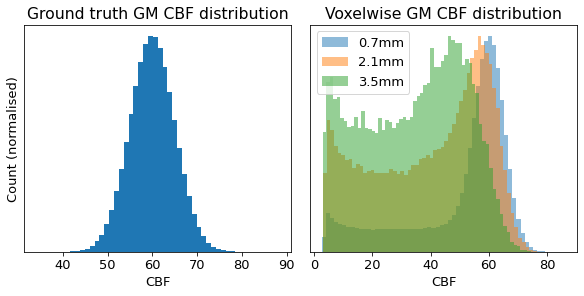

In [23]:
spc = rt.ImageSpace('tob_all_stacked_0.7.nii.gz')
pvs = nib.load('tob_all_stacked_0.7.nii.gz').get_fdata()

fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4))

cbf_samples = np.random.normal(60, 5, size=spc.size)
axes[0].hist(cbf_samples.flatten(), 50)
axes[0].set_yticks([])
axes[0].set_xlabel('CBF')
axes[0].set_ylabel('Count (normalised)')
axes[0].set_title('Ground truth GM CBF distribution')

for i in range(1,6,2):
    
    new_spc = spc.resize_voxels(i)
    new_pvs = rt.Registration.identity().apply_to_array(pvs, spc, new_spc, order=1)
    new_mask = (new_pvs[...,0] > 0.05)

    cbf = np.random.normal(60, 5, size=new_spc.size) * new_pvs[...,0]
#     cbf += np.random.normal(20, 3, size=new_spc.size) * new_pvs[...,1]

    counts, bins = np.histogram(cbf[new_mask], 60)
    axes[1].bar(bins[1:], counts/counts.max(), width=bins[1]-bins[0], alpha=0.5)

axes[1].set_yticks([])
axes[1].set_xlabel('CBF')
axes[1].set_title('Voxelwise GM CBF distribution')
axes[1].legend(['0.7mm', '2.1mm', '3.5mm'])
plt.savefig('CBF_PVE_hists.png', dpi=200, bbox_inches='tight')

In [ ]:
plt.imshow(cbf[...,50])

In [ ]:
cbf.shape